# Waveform Generator

In [53]:
import numpy as np
import math
import json
import random

def waveforms(N_A, N_g, N_f, t0_tf, T, B, trials, seedn=1, inputfile="input", 
              phi0=0, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N=10000):

    # initalizes the arrays which span parameter space, and their lengths
    A_RANGE=np.linspace(A0,Af,N_A)
    G_RANGE=np.linspace(g0,gf,N_g)
    F_RANGE=np.linspace(F0,Ff,N_f)

    # number of parameters available
    A_LEN, G_LEN, F_LEN = N_A, N_g, N_f
    
    waveform_data={}
    for j in range(trials):
        waveform_data.update({j:[[],[]]})
        
        # calculates random indice for each parameter (A, f, g)
        A_RAN=random.randint(0,A_LEN-1)
        G_RAN=random.randint(0,G_LEN-1)
        F_RAN=random.randint(0,F_LEN-1)
        
        # calculates random parameters A, f, g
        A, gamma, f = A_RANGE[A_RAN], G_RANGE[G_RAN], F_RANGE[F_RAN]
        
        dt=T/N # time resolution

        t0=(T-t0_tf)*np.random.random(1)[0]  # randomly generate start time
        START_INDEX=math.floor(t0/dt)        # find index associated with time

        ##NOTE: using 't0' instead of some multiple of dt may cause issues later
        
        SIG_LEN = (math.floor(t0_tf/dt)+1 if (t0_tf != T) else N) # calculate # of indexes signal takes
        INJECTED = np.zeros(N)                 # initalize injected signal, with N size array of zeroes
        for i in range(SIG_LEN):
            INJECTED[START_INDEX + i]=t0+i*dt       # fill in injected signal with its time stamps

        w = 2 * np.pi * f
        
        # replace timestamps with their displacement values
        SR = INJECTED[START_INDEX : START_INDEX+SIG_LEN][:]
        INJECTED[START_INDEX : START_INDEX+SIG_LEN] = A*np.sin(w*(SR-t0) + phi0)*np.exp(-gamma*(SR-t0))
        
        # Purposed for Quadrature Sum
        D_i = [] # list of each differently seeded waveform
        for n in range(seedn):
            np.random.seed(seed = n)
            NOISE = np.random.normal(scale=(B/(math.sqrt(3)*2)), size=N)  # Noise!
            D_i.append(list(NOISE + INJECTED))  # complete data!
        
        # gets parameters and data for each trial, stuffs it into dictionary
        parameters = [A, f, gamma, t0]
        waveform_data[j][0], waveform_data[j][1] = parameters, D_i
        
    # each trial has list of parameters used and list of data values
    with open("run_uniques/{}-waveform_data.json".format(inputfile) , "w") as f:
        json.dump(waveform_data, f, indent=2, sort_keys=True)

In [54]:
# waveforms(N_A, N_g, N_f, t0_tf, T, B, trials, seedn=1, inputfile="input", 
#               phi0=0, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N=10000):

waveforms(4,4,4,4,10,0,10,seedn=1,inputfile="input",phi0=0,A0=1,Af=50,g0=0,gf=2,F0=90,Ff=110,N=250)

# Statistic Analysis (per trial)
#### Don't forget to input to statudio the number of trials you intend to read from the waveform_data (VERY IMPORTANT)

In [55]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import time

# Produces a template given a position in parameter space
def template(A, f, gamma, duration, dt):
    t = np.arange(0, duration + dt, dt)
    w = 2 * np.pi * f
    return A * np.sin(w*t)*np.exp(-gamma*t)

# Produces a cross corelation function given a data input and a template in parameter space
def CrossCorrelation(data, template, dt):
    ii = 0
    M = []

    while len(data[ii:]) >= len(template):
        M.append(np.sum((data[ii: len(template) + ii] * template)))
        ii+=1

    return M

# Produces chi square at each "slide"
def ChiSquare(data, template, dt):
    ii = 0
    C = []

    while len(data[ii:]) >= len(template):
        C.append(-1 * np.sum((data[ii: len(template) + ii] - template) ** 2))
        ii += 1

    return C

def modulator(rho_ij, D, dt):

    rho_mod_D, RHO_ij = [] , rho_ij[:]

    dn , L = math.floor(2*D/dt) , len(RHO_ij)

    for i in range(0,L-(L%dn),dn):
        rho_mod_D.append(max(RHO_ij[i:i+dn]))

    if (L-(L%dn)) != L :
        rho_mod_D.append(max(RHO_ij[L-(L%dn):L]))

    return rho_mod_D

def statudio(trialn, D, N_A, N_g, N_f, t0_tf, T, trials, run1 = True,
                  seedn=1, inputfile="input", A0=1, Af=50, g0=0, gf=2,
                  F0=90, Ff=110, N_t=10000):

    # initalizes the arrays which span parameter space, and their lengths
    A_RANGE=np.linspace(A0,Af,N_A)
    G_RANGE=np.linspace(g0,gf,N_g)
    F_RANGE=np.linspace(F0,Ff,N_f)

    A_LEN, G_LEN, F_LEN = N_A, N_g, N_f

    # constructs timestep resolution, and saves N and t0/tf internally 
    N, dt = N_t, T/N_t

    # constructs time range to pick injected signal start time from/ corresponding length 
    t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/(T)))))
    t_LEN=len(t_RANGE)

    # initialize arrays for various data/cross-correlations/chi-squares 
    noise = []

    # constructs all templates which correspond to points in the parameter space
    TEMPLATES_AFG=[ template( A, f, g, t0_tf, dt) for A in A_RANGE 
                   for g in G_RANGE for f in F_RANGE]

    AFG_PAIR=[ [A, f, g] for A in A_RANGE 
                   for g in G_RANGE for f in F_RANGE]

    # Reads waveform data file 
    with open("run_uniques/{}-waveform_data.json".format(inputfile),"r") as f: 
        waveform_data = json.load(f)

    waveform_data = waveform_data[str(trialn)] # trialn's parameters and differently seeded data
    
    output={}

    output.update({trialn:[[],[],[],[]]})

    # isolates random a-g-f pair / data set 
    temp_AGFT, data = waveform_data[0], waveform_data[1]

    noise.append(data) 

    output[trialn][0], output[trialn][1] = temp_AGFT, data  # stores random a-g-f pair / data set 

    Quad_CRS = []
    Quad_CHI = []
    
    # performs base static calculation across parameter space
    # Quadrature Sum
    for n in range(seedn): # Use seedn as index for data

        CRS_COR, CHI_SQR = [[],[]]

        for temp in TEMPLATES_AFG:

            CC_dh = list(CrossCorrelation(data[n], temp, dt))
            CRS_COR.append(CC_dh)

            CS_dh = list(ChiSquare(data[n], temp, dt))
            CHI_SQR.append(CS_dh)

        Quad_CRS.append(CRS_COR) # now a 3d list of seedn statistics, with 2d list statistics per waveform
        Quad_CHI.append(CHI_SQR)

    CRS_COR = np.sum(np.array(Quad_CRS) ** 2, axis = 0) ** .5 # Quadrature sum of each seed's statistic
    CHI_SQR = np.sum(np.array(Quad_CHI) ** 2, axis = 0) ** .5

    # stores base statistics to attribute
    cross_cor = CRS_COR
    chi = CHI_SQR
    output[trialn][2], output[trialn][3] = CRS_COR.tolist(), CHI_SQR.tolist() # store quadrature summed based statistics
    
#calculates test statistic, stores it internally,
#and returns a copy of it as a dictionary 
# trying connect stat and anlysis function
    
    # counts number of tempates in parameter space
    PSPACE_LEN = len(AFG_PAIR)
    
    # String to equation!
    stats = ["CC_IJ","CS_IJ","CC_IJ/abs((1+CS_IJ))"]

    # initalizes rho statistic dictionary/stat outputs collector
    RHO = {}
    stat_outputs = []
    
    for stat in stats: # objective is that the appropriate jsons holds multiple stat results

        # indexed to loops through parameter space templates and
        # calculates each rho_ij given template j
        rho_i = []
        for j in range(PSPACE_LEN):
            CC_IJ = np.array(cross_cor[j][:])
            CS_IJ = np.array(chi[j][:])

            # Evaluates string (Exec gave issues... eval is the same concept though)
            p = eval(stat)
            rho_i.append(list(p))
        stat_outputs.append(rho_i) # stat_outputs is 3d list holding a 2d list of a stat's outputs for each template
    RHO.update({ trialn : stat_outputs })

    if (2*D >= dt):
        
        # gets the length of linearized template space
        TEMP_LEN=len(cross_cor) # number of templates 

        RHO_MOD={}
        MAX_OS={}
        MAX_BG_TEMP={}
        BG_VALS_IJ, FG_VAL_IJ = [], []
        pot_thresholds = {}
        
        # seperates fg value from bg value
        T0_2D = math.floor(output[trialn][0][3]/(2*D))

        for j in range(TEMP_LEN):
            MAX_BG_TEMP.update({ j : list(np.zeros(len(stats)))})

        for stat in range(len(stats)):
            
            pot_thresholds.update({stat:[]})
            
            BG_VALS_ij, FG_VAL_ij = [], []
            for j in range(TEMP_LEN):

                # calculates bg values + fg values
                BG_VALS_ij.append(modulator(RHO[trialn][stat][j][:],D,dt))

                FG_VAL_ij.append(BG_VALS_ij[j].pop(T0_2D))
                    
            BG_VALS_IJ.append(BG_VALS_ij) # 3d list
            FG_VAL_IJ.append(FG_VAL_ij) # 2d list
            
            pot_thresholds[stat] += FG_VAL_ij # for each stat key, forground values of trialn are added
        RHO_MOD.update({ trialn: [ BG_VALS_IJ, FG_VAL_IJ ] }) # these are the peaks we look for
        
        stat_dict = {}
        for stat in range(len(stats)):
            stat_dict.update({stat:[tuple(output[trialn][0][0:3]),max(RHO_MOD[trialn][1][stat])] })
        MAX_OS.update({trialn: stat_dict}) # stores t0 and forground peaks for each trial

        for stat in range(len(stats)):
            for j in range(TEMP_LEN):
                new_max=max(RHO_MOD[trialn][0][stat][j]) # max ofsource peak for each template

                MAX_BG_TEMP[j][stat] = new_max # every value in MAX_BG_TEMP dictionary changes from 0 to that templates max
    else: 
        print("invalid D; it is required that 2*D >= T/N")

    # All jsons below will serve post processing

    # output holds trialn's parameters, data, cross-correlation, chi-square
    with open("output_folder/output_{}.json".format(trialn), "w") as f: 
        json.dump(output, f, indent=2, sort_keys=True)

    # RHO_MOD holds trialn's background and forground values
    with open("Peaks_folder/Peaks_{}.json".format(trialn), "w") as f:
        json.dump(RHO_MOD, f, indent=2, sort_keys=True)

    # MAX_OS holds trialn's max onsource peak
    with open("Max_OS_folder/Max_OS_{}.json".format(trialn), "w") as f:
        json.dump(MAX_OS, f, indent=2, sort_keys=True)
    
    # MAX_BG_TEMP and pot_thresholds were devised wrong. They used to rewrite the same file with
    # changed or more value in every run. This won't work when parallelized as some runs may finish
    # faster than even the first. They are now made for each trial, but because of their different form
    # compared to the simple first three, weirder json combiners must be used on them

    with open("Max_BG_TEMP_folder/Max_BG_TEMP{}.json".format(trialn), "w") as f: # Merged
        json.dump(MAX_BG_TEMP, f, indent=2, sort_keys=True)
        
    with open("thresholds_folder/thresholds{}.json".format(trialn), "w") as f:
        json.dump(pot_thresholds, f, indent=2, sort_keys=True)
    
    # Now only the essentials file is made when run1 is True
    # essentials holds all the values that don't change for each trialn run
    if run1 == True:
        essent = {"essentials":[A_LEN,F_LEN,G_LEN,list(F_RANGE),list(A_RANGE),list(G_RANGE),AFG_PAIR,trials,stats]}
        with open("run_uniques/essentials.json", "w") as f:
            json.dump(essent, f, indent=2, sort_keys=True)

In [56]:
# def statudio(trialn, D, N_A, N_g, N_f, t0_tf, T, trials, run1 = True,
#                   seedn=1, inputfile="input", A0=1, Af=50, g0=0, gf=2,
#                   F0=90, Ff=110, N_t=10000):

statudio(0, .02, 4, 4, 4, 4, 10, 3, N_t=250, seedn=1, run1=True)
statudio(1, .02, 4, 4, 4, 4, 10, 3, N_t=250, seedn=1, run1=False)
statudio(2, .02, 4, 4, 4, 4, 10, 3, N_t=250, seedn=1, run1=False)

# Json Combiner

In [57]:
import glob
import json

# works like a charm, put in your path and
# make sure to include the path of the produced json in their merge name

# This function will be run on the jsons of output, RHO_MOD, and MAX_OS
# It updates all trial dictionaries, and since each dictionary has a different key 
# (which indicates the trial used), then will be added, till 1 dictionary for all
# trials is made

def json_stack_keys(jsons_path, merge_path_name):
    
    # Include last / at end of path!
    files = glob.glob("{}*.json".format(jsons_path))

    count = 0
    for file in files:
        if count == 0:
            count += 1
            with open(file, "r") as f:
                C_dictionary = json.load(f)
        else:
            with open(file, "r") as f:
                C_dictionary.update(json.load(f))

    with open('{}.json'.format(merge_path_name), 'w') as f:
        json.dump(C_dictionary, f, indent=2)

# This function will be run on the jsons of MAX_BG_TEMP
# MAX_BG_TEMP always has the same keys, as they are the templates used per trial
# As such we update the max offsource value for each stat of each template of each trial
# We therefore have the crosses across all trials

def json_update_components(jsons_path, merge_path_name):
    
    with open("Merged_jsons/Merged_Peaks.json", "r") as f:
        RHO_MOD = json.load(f)
    
    # way of getting the first key of a dictionary, used to get tempn and statn quick and dirty
    get_first_key = []
    get_first_key += RHO_MOD.keys()
    dict_key = get_first_key[0]
    
    # way of getting tempn and statn from RHO_MOD
    tempn = len(RHO_MOD[dict_key][0][0])
    statn = len(RHO_MOD[dict_key][0])
    
    # Include last / at end of path!
    files = glob.glob("{}*.json".format(jsons_path))

    count = 0
    for file in files:
#         trialn = "" # method of obtaining this file's trialnumber through its name
#         for character in file:
#             if character.isdigit():
#                 trialn += str(character)
#         trialn = int(trialn)

        if count == 0:
            count += 1
            with open(file, "r") as f:
                C_dictionary = json.load(f)
        else:
            with open(file, "r") as f:
                C_dictionary_new = json.load(f)
                
            for stat in range(statn):
                for j in range(tempn):
                
                    if (C_dictionary_new[str(j)][stat] > C_dictionary[str(j)][stat]): # every value in MAX_BG_TEMP dictionary changes from 0 to that templates max
                        C_dictionary[str(j)][stat] = C_dictionary_new[str(j)][stat]

    with open('{}.json'.format(merge_path_name), 'w') as f:
        json.dump(C_dictionary, f, indent=2)

# This function will be run on the jsons of pot_threshold
# pot_thresholds is a 2d list, where each list is a stat's onsource peaks for a trial
# The lists will have each trials values added to them until we havethe onsource peaks for all trials 

def json_list_append(jsons_path, merge_path_name):

    # Include last / at end of path!
    files = glob.glob("{}*.json".format(jsons_path))

    count = 0
    for file in files:
        if count == 0:
            count += 1
            with open(file, "r") as f:
                C_dictionary = json.load(f)
        else:
            with open(file, "r") as f:
                C_dictionary_new = json.load(f)
        
            for i in C_dictionary:
                C_dictionary[str(i)] += C_dictionary_new[str(i)]

    with open('{}.json'.format(merge_path_name), 'w') as f:
        json.dump(C_dictionary, f, indent=2)

In [58]:
json_stack_keys("output_folder/", "Merged_jsons/Merged_output")

In [59]:
json_stack_keys("Peaks_folder/", "Merged_jsons/Merged_Peaks")

In [60]:
json_stack_keys("Max_OS_folder/", "Merged_jsons/Merged_Max_OS")

In [61]:
json_update_components("MAX_BG_TEMP_folder/", "Merged_jsons/Merged_MAX_BG_TEMP")

In [62]:
json_list_append("thresholds_folder/", "Merged_jsons/Merged_thresholds")

# Plotters

In [63]:
def test_plotter(T, N, var1=0, var2=0,bg_test=True,stat=2,plot1="test_plot1",plot2="test_plot2"):

    with open("run_uniques/essentials.json", "r") as f:
        essentials = json.load(f)
    A_LEN = essentials["essentials"][0]
    F_LEN = essentials["essentials"][1]
    G_LEN = essentials["essentials"][2]
    F_RANGE = essentials["essentials"][3]
    A_RANGE = essentials["essentials"][4]
    G_RANGE = essentials["essentials"][5]
    AFG_PAIR = essentials["essentials"][6]
    trials = essentials["essentials"][7]

    with open("Merged_jsons/Merged_output.json", "r") as f:
        output = json.load(f)
    
    with open("Merged_jsons/Merged_Peaks.json", "r") as f:
        RHO_MOD = json.load(f)

    # Calculates the index of the attribute variable
    # (A, F, or G) which the heat map should marginalize
    # over
    if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
        if ((0<= var1) and (0<= var2)):  #checks if range valid
            if (var2 < var1):            #properly orders
                var1, var2 = var2, var1
                index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            elif (var2==var1):
                index=var2  # if the values are the same, set as index

            else:
                index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

        else:
            print("improper index inputs: both must be >= 0")
            index=0
    else:
        print("improper index inputs: both must be <= 2")
        index=0

    mapping={}   #initalizes mapping for heat map

    holder=np.full((A_LEN, F_LEN, G_LEN), 0, dtype=list)

    # builds link between keys and np-array 
    for j in range(F_LEN):
        for i in range(A_LEN):
            for k in range(G_LEN):
                F=F_RANGE[j]
                A=A_RANGE[i]
                G=G_RANGE[k]

                holder[(i,j,k)]=[0]
                mapping.update({ (A,F,G) : holder[(i,j,k)]})

    #initalizes threshold axis points, counts for each threshold
    #and space of parameter space
    THRS_AXIS=[]
    COUNT_AXIS=[]
    PSPACE_LEN=len(AFG_PAIR)
    PSACE_PAIRS=[]

    #sets current threshold value
    # how many templates succeeded per threshold (succ_count_thrhld), how many trials succeeded per threshold (heatcount)
    for thrshld in np.linspace(0,T,N):

        THRS_AXIS.append(thrshld)
        succ_count_thrhld=0

        #loops from trial/ parameter space pairs 
        for i in range(trials):
            heat_count=0
            for j in range(PSPACE_LEN):
                
                RM_ij=np.array(RHO_MOD[str(i)][0][stat][j])
                FG_ij=RHO_MOD[str(i)][1][stat][j]
                N_BG_ij=len(RM_ij[ RM_ij > FG_ij])

                #tests if the given pair passes the threshold test
                if (bg_test==True):
                    if ((N_BG_ij==0) and (FG_ij > thrshld)): # (per template) offsource peaks < onsource peak, onsource peak > threshold

                        if heat_count==0:
                            succ_count_thrhld+=1
                            mapping[tuple(output[str(i)][0][:3])][0]+=1 # adds 1 to that paramater combo's value, default is 0 
                            heat_count+=1
                else:
                    if (FG_ij > thrshld): # (per template) onsource peak > threshold

                        if heat_count==0:
                            succ_count_thrhld+=1
                            mapping[tuple(output[str(i)][0][:3])][0]+=1 # adds 1 to that paramater combo's value, default is 0 
                            heat_count+=1

        COUNT_AXIS.append(succ_count_thrhld)

    plt.plot(THRS_AXIS,COUNT_AXIS)
    plt.xlabel("$Threshold$")
    plt.ylabel("Counts")
    plt.show()
    plt.savefig("plots/{}.png".format(plot1))
    plt.clf()

    #redefines things to be normal arrays inside
    for j in range(F_LEN):
        for i in range(A_LEN):
            for k in range(G_LEN):
                holder[(i,j,k)]=holder[(i,j,k)][0] # I think [0] is making the list value for each parameter combo just its value

    #marginalizes array in direction of index
    index=int(index) # index is still weird
    w=holder.sum(index)

    #builds a copy of the original array, but fixes things to be integers 
    cop=np.full(w.shape,0) # array in shape of marginalized array of holder values
    z=[(i,j) for i in range(w.shape[0]) for j in range(w.shape[1])] 
    for tup in z: # z holds the index for cop, these indexes are each of two variables in use
        cop[tup]=int(w[tup])

    label=np.array(["amplitude","frequency", "gamma"])
    x=np.array([0, 1, 2])
    x=x[ x != index] # parameter index that aren't index are used

    plt.imshow( cop, cmap=plt.cm.hot)
    plt.xlabel(label[x[1]])
    plt.ylabel(label[x[0]])
    plt.savefig("plots/{}.png".format(plot2))

    #plt.imshow( heat_array, cmap=plt.cm.hot) 

def ROC_Data(T0, Tf, N, stat):

    with open("run_uniques/essentials.json", "r") as f:
        essentials = json.load(f)
    A_LEN = essentials["essentials"][0]
    F_LEN = essentials["essentials"][1]
    G_LEN = essentials["essentials"][2]
    F_RANGE = essentials["essentials"][3]
    A_RANGE = essentials["essentials"][4]
    G_RANGE = essentials["essentials"][5]
    AFG_PAIR = essentials["essentials"][6]
    trials = essentials["essentials"][7]
    
    with open("Merged_jsons/Merged_Peaks.json", "r") as f:
        RHO_MOD = json.load(f)

    PSPACE_LEN=len(AFG_PAIR)

    # Stats per threshold
    Detection_Prob = []
    New_False_Prob = []

    #sets current threshold value
    for thrshld in np.linspace(T0,Tf,N):

        # Detection/ False Alarm probability counters
        Detect_count = 0
        False_count = 0

        #loops from trial/ parameter space pairs 
        for i in range(trials):

            # Detection Probability
            Max_FG_ij = max(RHO_MOD[str(i)][1][stat]) # max of onsources per trial
            if Max_FG_ij > thrshld:
                Detect_count += 1

            for j in range(PSPACE_LEN):

                RM_ij=np.array(RHO_MOD[str(i)][0][stat][j])

                # False Alarm probability
                falses_ij = len(RM_ij[RM_ij > thrshld])
                False_count += falses_ij

        # Detection/False Alarm probability stats
        Detect_stat = Detect_count / trials
        False_stat = False_count / (len(RHO_MOD[str(i)][0][stat][0]) * PSPACE_LEN * trials)

        # Appending stat per threshold
        Detection_Prob.append(Detect_stat)
        New_False_Prob.append(False_stat)
        
    return(Detection_Prob, New_False_Prob)

def ROC_Curve(N, outputfile="ROC_test"):
    
    with open("run_uniques/essentials.json", "r") as f:
        essentials = json.load(f)
    stat_list = essentials["essentials"][8]

    
    with open("Merged_jsons/Merged_thresholds.json", "r") as f:
        Thresholds = json.load(f)
    
    tempn = len(Thresholds)
    
    for s in range(tempn):
        
        thresholds = Thresholds[str(s)]

        Detection_Prob, New_False_Prob = ROC_Data(min(thresholds), max(thresholds), N, s)
        plt.plot(New_False_Prob, Detection_Prob, label=stat_list[s])

    plt.xlabel("New_False_Probs")
    plt.ylabel("Detection_Probs")
    plt.title("ROC Curve:N={}".format(N))
    plt.legend()
    plt.savefig("plots/{}.png".format(outputfile))
    plt.show()

def Scatter_plotter(thrshld, xvar, yvar, stat=2, plot="Scatter_plot"): 

    with open("run_uniques/essentials.json", "r") as f:
        essentials = json.load(f)
    A_LEN = essentials["essentials"][0]
    F_LEN = essentials["essentials"][1]
    G_LEN = essentials["essentials"][2]
    F_RANGE = essentials["essentials"][3]
    A_RANGE = essentials["essentials"][4]
    G_RANGE = essentials["essentials"][5]
    AFG_PAIR = essentials["essentials"][6]
    trials = essentials["essentials"][7]

    with open("Merged_jsons/Merged_output.json", "r") as f:
        output = json.load(f)

    with open("Merged_jsons/Merged_Peaks.json", "r") as f:
        RHO_MOD = json.load(f)

    label=["amplitude","frequency", "gamma"]
    PSPACE_LEN=len(AFG_PAIR)
    SUCC_PAIRS=([],[])
    FAIL_PAIRS=([],[])

    #loops from trial/ parameter space pairs 
    for i in range(trials):

        succ_count_thrhld=0  #test condition for adding to fail array

        for j in range(PSPACE_LEN):

            RM_ij=np.array(RHO_MOD[str(i)][0][stat][j])  #get moded rho_ij background values
            FG_ij=RHO_MOD[str(i)][1][stat][j]            #get moded rho_ij foreground value
            N_BG_ij=len(RM_ij[ RM_ij > FG_ij])     # get background vals > froeground vals

            #tests if the given pair passes the threshold test
            if ((N_BG_ij==0) and (FG_ij > thrshld)):

                parameter_x=output[str(i)][0][xvar]  #get parameter 'xvar' of trial i
                parameter_y=output[str(i)][0][yvar]  #get parameter 'yvar' of trial i
                SUCC_PAIRS[0].append(parameter_x) #add to successes
                SUCC_PAIRS[1].append(parameter_y)
                succ_count_thrhld+=1
                break

        #sees if trial i failed the test; adds parameters to fail array
        if succ_count_thrhld==0:
            parameter_x=output[str(i)][0][xvar]
            parameter_y=output[str(i)][0][yvar]
            FAIL_PAIRS[0].append(parameter_x)
            FAIL_PAIRS[1].append(parameter_y)

    colors = ("red", "blue")
    groups = ("pass", "fail")
    marks = ("o", "*")
    data = ( SUCC_PAIRS, FAIL_PAIRS )

    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for data, marks, color, group in zip(data, marks, colors, groups):
        x , y = data
        ax.scatter(x, y, marker=marks, c=color, edgecolors='none', s=30, label=group)

    plt.title('found-missed plot')
    plt.xlabel(label[xvar])
    plt.ylabel(label[yvar])
    plt.legend(loc=2)
    plt.show()
    plt.savefig("plots/{}".format(plot))
    
def index_counter(var1,var2):
    
    # Calculates the index of the attribute variable
    # (A, F, or G) which the heat map should marginaliz 
    # over
    if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
        if ((0<= var1) and (0<= var2)):  #checks if range valid
            if (var2 < var1):            #properly orders
                var1, var2 = var2, var1
                index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            elif (var2==var1):
                index=var2  # if the values are the same, set as index

            else:
                index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

        else:
            print("improper index inputs: both must be >= 0")
            index=0
    else:
        print("improper index inputs: both must be <= 2")
        index=0

    return index

def heatmap(var1, var2, T, max_OS=-1, max_BG=-1, stat=2, plot1="heat_plot1", plot2 = "heat_plot2"):

    with open("run_uniques/essentials.json", "r") as f:
        essentials = json.load(f)
    A_LEN = essentials["essentials"][0]
    F_LEN = essentials["essentials"][1]
    G_LEN = essentials["essentials"][2]
    F_RANGE = essentials["essentials"][3]
    A_RANGE = essentials["essentials"][4]
    G_RANGE = essentials["essentials"][5]
    AFG_PAIR = essentials["essentials"][6]
    trials = essentials["essentials"][7]

    with open("Merged_jsons/Merged_output.json", "r") as f:
        output = json.load(f)
    
    with open("Merged_jsons/Merged_Max_OS.json", "r") as f:
        MAX_OS = json.load(f)

    with open("Merged_jsons/Merged_Max_BG_TEMP.json", "r") as f:
        MAX_BG_TEMP = json.load(f)
    
    index=index_counter(var1,var2)

    mapping={}   #initalizes mapping for heat map
    count_mapping={} #initalies array to count occurances of certain parameters
    BG_mapping={}

    holder=np.full((A_LEN, F_LEN, G_LEN), 0, dtype=list)
    count_holder=np.full((A_LEN, F_LEN, G_LEN), 0, dtype=list)
    BG_holder=np.full((A_LEN, F_LEN, G_LEN), 0, dtype=list)

    # builds link between keys and np-array 
    for j in range(F_LEN):
        for i in range(A_LEN):
            for k in range(G_LEN):
                F=F_RANGE[j]
                A=A_RANGE[i]
                G=G_RANGE[k]

                holder[(i,j,k)]=[0]
                count_holder[(i,j,k)]=[0]
                BG_holder[(i,j,k)]=[0]

                mapping.update({ (A,F,G) : holder[(i,j,k)]})
                count_mapping.update({ (A,F,G) : count_holder[(i,j,k)]})
                BG_mapping.update({ (A,F,G) : BG_holder[(i,j,k)]})

    #form BG mappings
    num_j=0
    for j in AFG_PAIR:
        BG_mapping[tuple(j)][0]=MAX_BG_TEMP[str(num_j)][stat]
        num_j+=1

    # form OS mappings
    for OS in MAX_OS.values():
        if (T<=OS[str(stat)][1]):
            mapping[tuple(OS[str(stat)][0])][0]+=float(OS[str(stat)][1])
            count_mapping[tuple(OS[str(stat)][0])][0]+=1

    #redefines things to be normal arrays inside 
    for j in range(F_LEN):
        for i in range(A_LEN):
            for k in range(G_LEN):
                holder[(i,j,k)]=holder[(i,j,k)][0]
                count_holder[(i,j,k)]=count_holder[(i,j,k)][0]
                BG_holder[(i,j,k)]=BG_holder[(i,j,k)][0]

    #marginalizes array in direction of index
    index=int(index)
    plot_array=holder.sum(index)
    normalizer=count_holder.sum(index)
    BG_plot=BG_holder.sum(index)

    #builds a copy of the original array, but fixes things to be integers 
    pa_cop=np.full(plot_array.shape,0.0)
    n_cop=np.full(normalizer.shape,0.0)
    BG_cop=np.full(BG_plot.shape,0.0)
    z=[(i,j) for i in range(plot_array.shape[0]) for j in range(plot_array.shape[1])]
    for tup in z:
        pa_cop[tup]=plot_array[tup]
        n_cop[tup]=normalizer[tup]
        BG_cop[tup]=BG_plot[tup]

    #normalize
    pa_cop[n_cop>0]=pa_cop[n_cop>0]/n_cop[n_cop>0]

    if (max_OS==-1):
        vmax_val=pa_cop.max()
    else:
        vmax_val=max_OS

    label=np.array(["A", "F", "G"])
    IL=np.array([0, 1, 2])
    IL=IL[ IL != index]

#     XV="self."+label[IL[1]]+"_RANGE"
    XV=label[IL[1]]+"_RANGE"
    XA=eval(XV)

#     YV="self."+label[IL[0]]+"_RANGE"
    YV=label[IL[0]]+"_RANGE"
    YA=eval(YV)

    contours = plt.contour(XA, YA, pa_cop, 10, colors='blue')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.contourf(XA, YA, pa_cop, 100, cmap='hot', alpha=1, vmin=T, vmax=vmax_val);
    plt.colorbar();

    plt.xlabel(label[IL[1]])
    plt.ylabel(label[IL[0]])
    plt.title('Max On Source; t='+str(T))
    plt.show()
    plt.savefig("plots/{}".format(plot1))
    
    if (max_BG==-1):
        vmax_val=BG_cop.max()
    else:
        vmax_val=max_BG

    contours = plt.contour(XA, YA, BG_cop, 10, colors='blue')
    plt.clabel(contours, inline=True, fontsize=8)

    plt.contourf(XA, YA, BG_cop, 100, cmap='hot', alpha=1, vmin=T, vmax=vmax_val);
    plt.colorbar();

    plt.xlabel(label[IL[1]])
    plt.ylabel(label[IL[0]])
    plt.title('Max Background; t='+str(T))
    plt.show()
    plt.savefig("plots/{}".format(plot2))

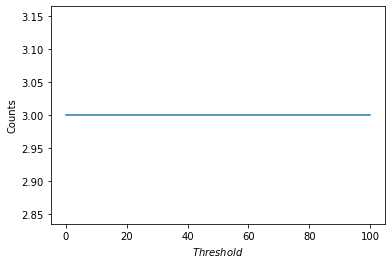

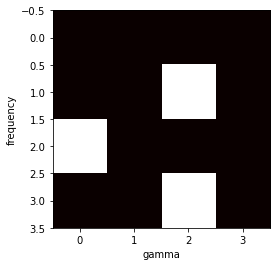

In [64]:
# def test_plotter(T, N, var1=0, var2=0, bg_test=True, stat=2, plot1="test_plot1", plot2="test_plot2"):
test_plotter(100, 300, var1=0, var2=0, bg_test=True, stat=2, plot1="test_plot1", plot2="test_plot2")

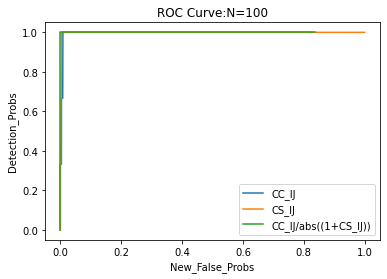

In [65]:
# def ROC_Curve(N, outputfile="ROC_test"):
ROC_Curve(100, outputfile="ROC_test")

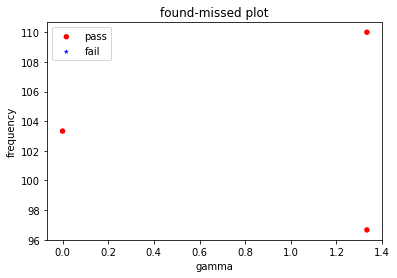

<Figure size 432x288 with 0 Axes>

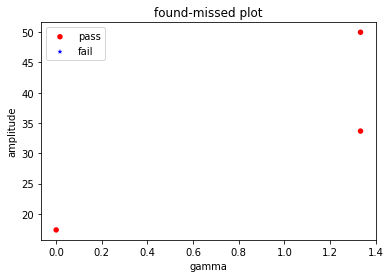

<Figure size 432x288 with 0 Axes>

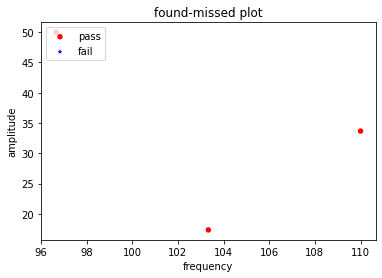

<Figure size 432x288 with 0 Axes>

In [66]:
# def Scatter_plotter(thrshld, xvar, yvar, stat=2, plot="Scatter_AvG_plot"): 

#scatter plot of fails & passes given threshold t

# Amplitude vs. gamma
Scatter_plotter(4, 2, 1, stat=2, plot="Scatter_AvG_plot")

# Amplitude vs. frequency
Scatter_plotter(4, 2, 0, stat=2, plot="Scatter_AvF_plot")

# frequency vs. gamma
Scatter_plotter(3, 1, 0, stat=2, plot="Scatter_FvG_plot")

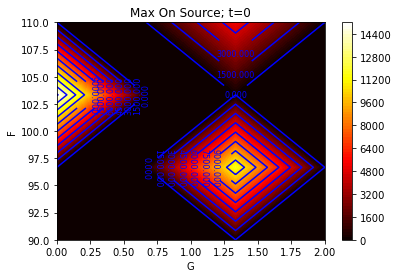

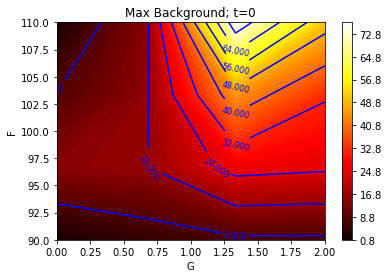

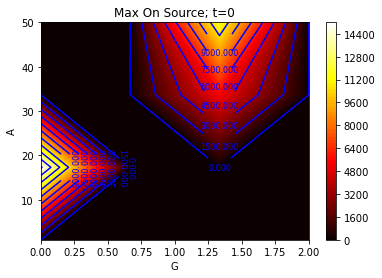

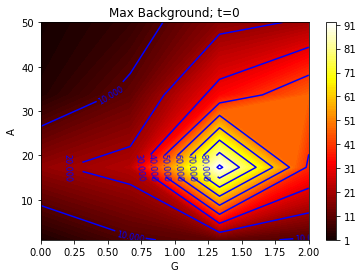

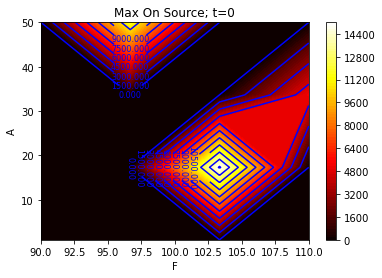

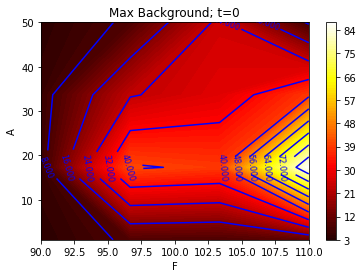

<Figure size 432x288 with 0 Axes>

In [67]:
# def heatmap(var1, var2, T, max_OS=-1, max_BG=-1, stat=2, plot1="heat_plot1", plot2 = "heat_plot2"):

#heat plot of 
#     1. average max onsource rho, over trials
#     2. max background rho, over templates

# Amplitude vs. gamma
heatmap(2, 1, 0, max_OS=-1, max_BG=-1, stat=2, plot1="heat_AvG_plot1", plot2 = "heat_AvG_plot2")

# # Amplitude vs. frequency
heatmap(2, 0, 0, max_OS=-1, max_BG=-1, stat=2, plot1="heat_AvF_plot1", plot2 = "heat_AvF_plot2")

# # frequency vs. gamma
heatmap(1, 0, 0, max_OS=-1, max_BG=-1, stat=2, plot1="heat_FvG_plot1", plot2 = "heat_FvG_plot2")